### Loading the data frame for the project work

In [3]:
import pickle

# Specify the file path
file_path = 'df_exp1.pkl' #ändern

# Load the pickle file
with open(file_path, 'rb') as file:
    data = pickle.load(file)




In [32]:
# Import Necessary Libraries
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import Lasso

# Preprocess the Data and define the target column
target_column = 'N AufgewAmplitudeNom [MPa]'

# X is the feature matrix, and y is the target vector
X = data.drop(columns=[target_column])
y = data[target_column]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Encode categorical columns using OrdinalEncoder
encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

# Identify numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [33]:
# Scale numerical columns using MinMaxScaler
scaler = MinMaxScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

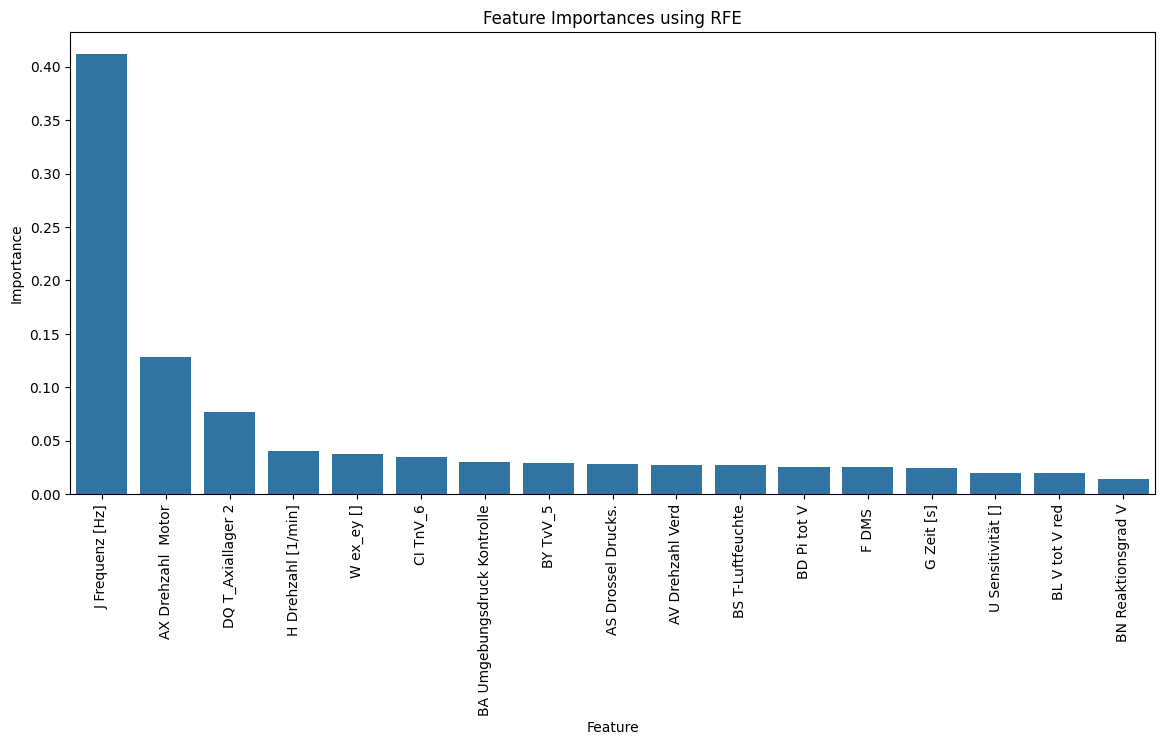

In [56]:
# Feature Selection using RFE
model = DecisionTreeRegressor(random_state=42)
k = 17  # You can adjust this number as needed
rfe = RFE(estimator=model, n_features_to_select=k, step=1)

# Fit RFE
rfe.fit(X, y)

# Get the mask of selected features and create a list of selected feature names
selected_features_rfe = X.columns[rfe.support_]

# Update X to only include selected features based on RFE
X_selected = X[selected_features_rfe]

# Refit the model with the selected features
dt_regressor.fit(X_selected, y)

# Feature Importances Plot
if hasattr(dt_regressor, 'feature_importances_'):
    feature_importances = pd.DataFrame({
        'Feature': selected_features_rfe,
        'Importance': dt_regressor.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(14, 6))
    sns.barplot(x='Feature', y='Importance', data=feature_importances)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importances using RFE')
    plt.xticks(rotation=90)
    plt.show()
else:
    print("The model does not have the feature_importances_ attribute.")

In [59]:
# Split the data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)


# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [15, 18, 21, 24, 27],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')

# Fit GridSearchCV to find the best parameters on the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_dt_regressor = grid_search.best_estimator_

# Perform cross-validation on the training data with the best model
cv_scores_train = cross_val_score(best_dt_regressor, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
mean_cv_mse_train = -cv_scores_train.mean()
std_cv_mse_train = cv_scores_train.std()

print(f'Cross-Validation Mean Squared Error(Train): {mean_cv_mse_train}')
print(f'Cross-Validation Std of Mean Squared Error(Train): {std_cv_mse_train}')

# Perform cross-validation on the testing data with the best model
cv_scores_test = cross_val_score(best_dt_regressor, X_test, y_test, cv=10, scoring='neg_mean_squared_error')
mean_cv_mse_test = -cv_scores_test.mean()
std_cv_mse_test = cv_scores_test.std()

print(f'Cross-Validation Mean Squared Error (Test): {mean_cv_mse_test}')
print(f'Cross-Validation Std of Mean Squared Error (Test): {std_cv_mse_test}')

# Fit the best model on the training data
best_dt_regressor.fit(X_train, y_train)
best_dt_parameter = grid_search.best_params_
print(f'Best hyperparameters for Decision Tree Regressor: {best_dt_parameter}')

# Predict on the training data
y_train_pred = best_dt_regressor.predict(X_train)

# Predict on the testing data
y_test_pred = best_dt_regressor.predict(X_test)

# Calculate performance metrics on training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate performance metrics on testing data
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Train Mean Squared Error: {train_mse}')
print(f'Train Mean Absolute Error : {train_mae}')
print(f'Train R-squared: {train_r2}')


print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Mean Absolute Error : {test_mae}')
print(f'Test R-squared: {test_r2}')


Cross-Validation Mean Squared Error(Train): 3.241152757925228
Cross-Validation Std of Mean Squared Error(Train): 0.3715662934597665
Cross-Validation Mean Squared Error (Test): 6.178138645001699
Cross-Validation Std of Mean Squared Error (Test): 0.8475206805178248
Best hyperparameters for Decision Tree Regressor: {'max_depth': 21, 'min_samples_leaf': 1, 'min_samples_split': 2}
Train Mean Squared Error: 0.0369342800437966
Train Mean Absolute Error : 0.05084850186564225
Train R-squared: 0.9991720875361114
Test Mean Squared Error: 2.8532372596284032
Test Mean Absolute Error : 1.0756462624736436
Test R-squared: 0.9313177456779096


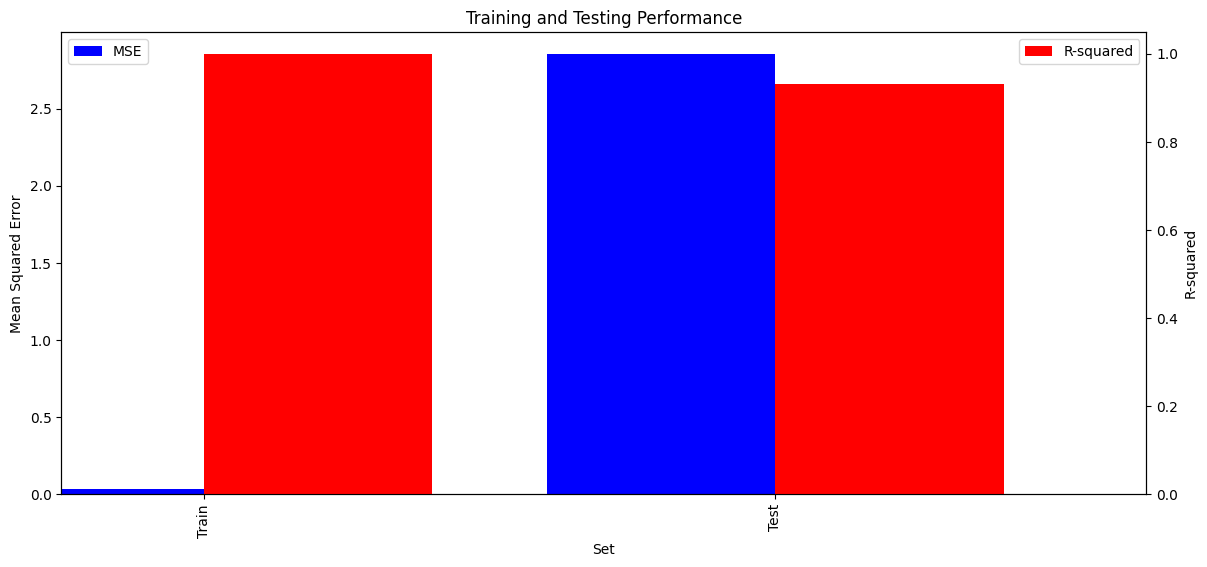

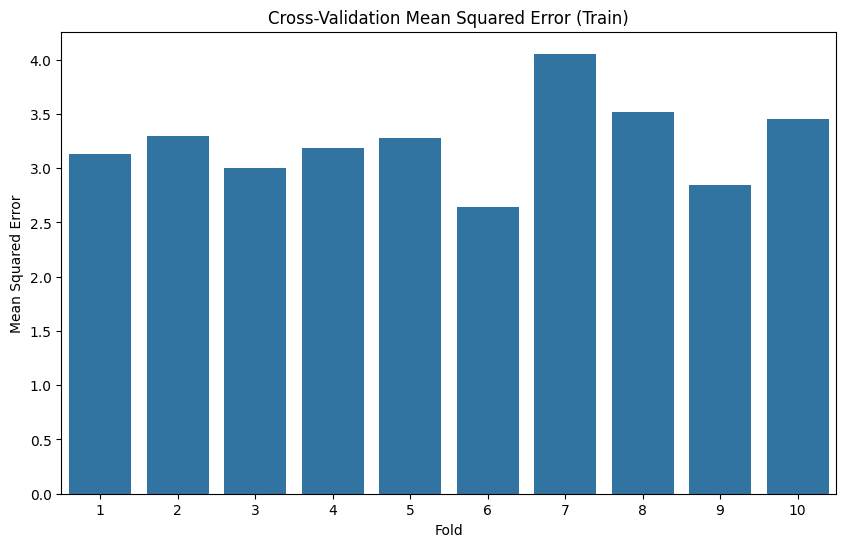

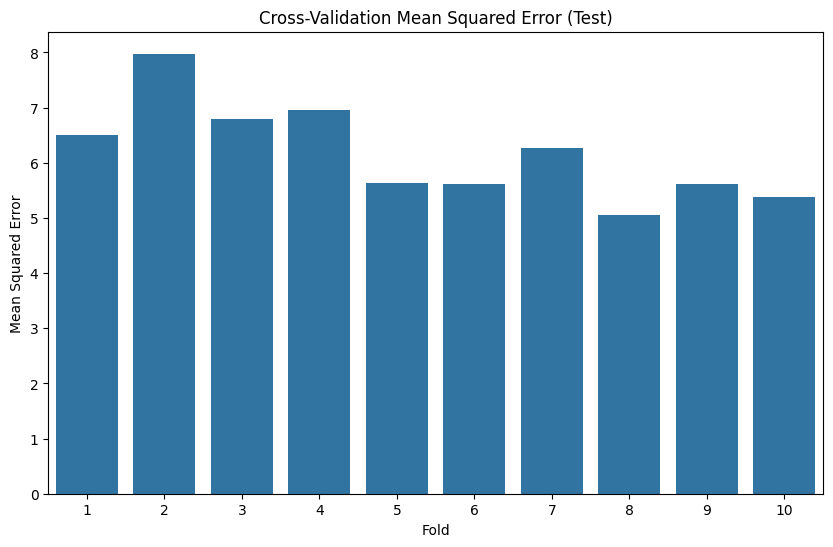

In [60]:
# Create a DataFrame for the metrics
metrics = pd.DataFrame({
    'Set': ['Train', 'Test'],
    'MSE': [train_mse, test_mse],
    'R-squared': [train_r2, test_r2]
})

# Plot MSE and R-squared for training and testing sets
fig, ax1 = plt.subplots(figsize=(14, 6))

ax2 = ax1.twinx()
width = 0.4

metrics['MSE'].plot(kind='bar', ax=ax1, width=width, position=1, label='MSE', color='blue')
metrics['R-squared'].plot(kind='bar', ax=ax2, width=width, position=0, label='R-squared', color='red')

ax1.set_ylabel('Mean Squared Error')
ax2.set_ylabel('R-squared')
ax1.set_xlabel('Set')
ax1.set_title('Training and Testing Performance')
ax1.set_xticklabels(metrics['Set'])
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Cross-validation Mean Squared Error with error bars for training data
cv_results_train = pd.DataFrame({
    'Fold': np.arange(1, len(cv_scores_train) + 1),
    'MSE': -cv_scores_train
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Fold', y='MSE', data=cv_results_train, errorbar='sd')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation Mean Squared Error (Train)')
plt.show()

# Cross-validation Mean Squared Error with error bars for testing data
cv_results_test = pd.DataFrame({
    'Fold': np.arange(1, len(cv_scores_test) + 1),
    'MSE': -cv_scores_test
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Fold', y='MSE', data=cv_results_test, errorbar='sd')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation Mean Squared Error (Test)')
plt.show()

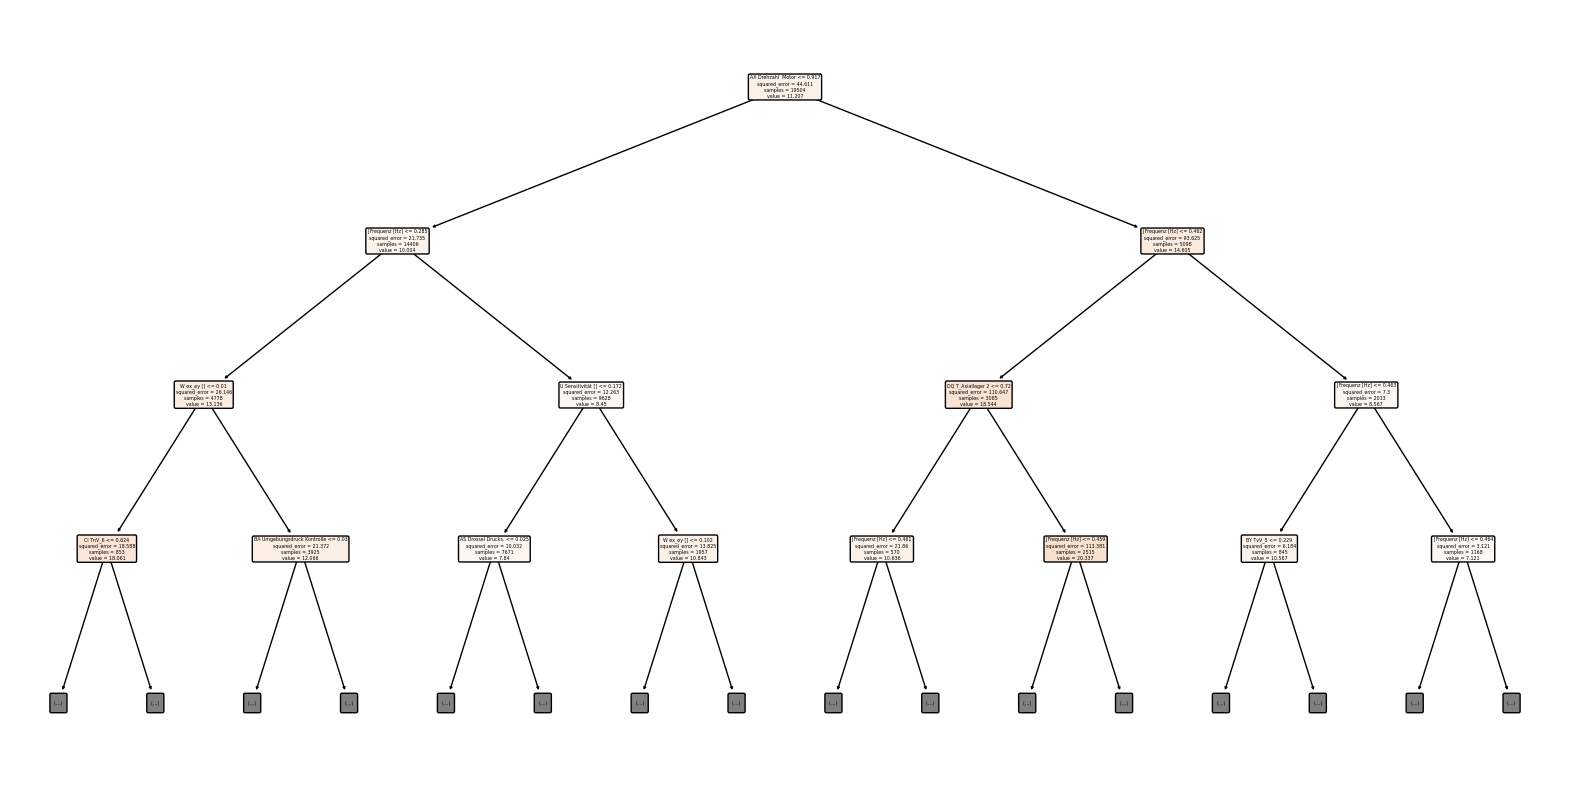

In [64]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot the tree with a limited depth
plt.figure(figsize=(20, 10))
plot_tree(best_dt_regressor, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3) 
plt.show()


In [9]:
#Import Necessary Libraries
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import uniform


#Preprocess the Data
target_column = 'N AufgewAmplitudeNom [MPa]'
X = data.drop(columns=[target_column])
y = data[target_column]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Encode categorical columns using OrdinalEncoder
encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

# Identify numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Scale numerical columns using MinMaxScaler
scaler = MinMaxScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Feature Selection using Mutual Information
k = 17
mi = mutual_info_regression(X, y)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
selected_features = mi_scores.index[:k]
X_selected = X[selected_features]

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_selected.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Split the Data (70% for training, 30% for testing)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

# Define Neural Network with 2 Hidden Layers
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, dropout_rate):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, 1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Define Custom Regressor for Sklearn
class NNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden1_size=32, hidden2_size=64, learning_rate=0.001, num_epochs=100, batch_size=64, dropout_rate=0.2):
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.model = NeuralNetwork(X_train.shape[1], self.hidden1_size, self.hidden2_size, self.dropout_rate)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def fit(self, X, y):
        self.model.train()
        dataset = torch.utils.data.TensorDataset(X, y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        for epoch in range(self.num_epochs):
            for batch_X, batch_y in loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            return self.model(X).numpy()

# Define Hyperparameter Search Space
param_distributions = {
    'hidden1_size': [32,64],
    'hidden2_size': [64,128],
    'learning_rate': [0.001, 0.01],
    'num_epochs': [100,200],
    'batch_size': [32, 64],
    'dropout_rate': [0.2, 0.3]
}

# Perform Randomized Search Cross-Validation
nn_regressor = NNRegressor()
random_search = RandomizedSearchCV(estimator=nn_regressor, param_distributions=param_distributions, n_iter=3, cv=3, scoring='neg_mean_squared_error', verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Best Model and Parameters
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Evaluate the Best Model
best_model.model.eval()
with torch.no_grad():
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    train_mse = mean_squared_error(y_train.numpy(), y_pred_train)
    test_mse = mean_squared_error(y_test.numpy(), y_pred_test)
    train_mae = mean_absolute_error(y_train.numpy(), y_pred_train)
    test_mae = mean_absolute_error(y_test.numpy(), y_pred_test)
    train_r2 = r2_score(y_train.numpy(), y_pred_train)
    test_r2 = r2_score(y_test.numpy(), y_pred_test)

print(f'Train Mean Squared Error: {train_mse}')
print(f'Test Mean Squared Error: {test_mse}')
print(f'Train Mean Absolute Error: {train_mae}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Train R-squared: {train_r2}')
print(f'Test R-squared: {test_r2}')


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END batch_size=64, dropout_rate=0.3, hidden1_size=32, hidden2_size=128, learning_rate=0.001, num_epochs=100; total time=  30.8s
[CV] END batch_size=64, dropout_rate=0.3, hidden1_size=32, hidden2_size=128, learning_rate=0.001, num_epochs=100; total time=  30.7s
[CV] END batch_size=64, dropout_rate=0.3, hidden1_size=32, hidden2_size=128, learning_rate=0.001, num_epochs=100; total time=  30.5s
[CV] END batch_size=64, dropout_rate=0.3, hidden1_size=64, hidden2_size=64, learning_rate=0.01, num_epochs=100; total time=  30.6s
[CV] END batch_size=64, dropout_rate=0.3, hidden1_size=64, hidden2_size=64, learning_rate=0.01, num_epochs=100; total time=  30.5s
[CV] END batch_size=64, dropout_rate=0.3, hidden1_size=64, hidden2_size=64, learning_rate=0.01, num_epochs=100; total time=  30.5s
[CV] END batch_size=32, dropout_rate=0.2, hidden1_size=32, hidden2_size=64, learning_rate=0.001, num_epochs=100; total time=  53.3s
[CV] END batch_si

## Optimal Hyperparameters Selection to Improve Model Performance

### Decision Tree Regressor
- **Parameter Grid**: `max_depth`, `min_samples_split`, `min_samples_leaf`.
- **Best Hyperparameters**: `max_depth=21`, `min_samples_split=2`, `min_samples_leaf=1`.
- **Model Performance on Training Data**: 
  - Mean Squared Error (MSE): 0.036
  - Mean Absolute Error (MAE): 0.050
  - R-squared: 0.999
- **Model Performance on Testing Data**:
  - Mean Squared Error (MSE): 2.853
  - Mean Absolute Error (MAE): 1.075
  - R-squared: 0.931
- **Observations**:
  - The decision tree regressor model showed strong performance, with a high R-squared value indicating a good fit and low MSE and MAE values confirming its predictive accuracy. 
  - Additionally, the model's variance is low, as the performance metrics for the training and testing data show little difference.
### Neural Network
- **Parameter Grid**: `hidden1_size`, `hidden2_size`, `learning_rate`, `num_epochs`,`batch_size`,`dropout_rate`.
- **Best Hyperparameters**: `hidden1_size=32`, `hidden2_size=64`, `learning_rate=0.001`, `num_epochs=100`,`batch_size=32`,`dropout_rate=0.2`
- **Model Performance on Training Data**: 
  - Mean Squared Error (MSE): 34.352
  - Mean Absolute Error (MAE): 3.902
  - R-squared: 0.229
- **Model Performance on Testing Data**:
  - Mean Squared Error (MSE): 32.633
  - Mean Absolute Error (MAE): 3.921
  - R-squared: 0.214
- **Observations**:
  - The neural network's performance is not as strong as that of the decision tree regressor.
  - The higher MSE and MAE values indicate that the neural network struggled to predict the target variable accurately.
  - The R-squared value shows that the model explains less variance in the data compared to the decision tree.
  - Additionally, the model exhibits low variance, as the performance metrics for training and testing data are quite similar. However, it has high bias, as it fails to predict accurate values compared to the actual data.


### Comparison of Feature Selection

| Sr.No | Method | No. of Features |  Alpha(Lasso) | MSE   | MAE   | R-squared |
|-------|--------|-----------------|-------------|-------|-------|-----------|
| 1     | Mutual Information | 50              | - | 5.137 | 1.501 | 0.876     |
| 2     | Mutual Information | 40              | - | 5.025 | 1.494 | 0.879     |
| 3     | Mutual Information | 30              | - | 5.301 | 1.519 | 0.872     |
| 4     | Mutual Information | 17              | - | 5.293 | 1.508 | 0.872     |
| 5     | Lasso              | -               | 0.001    | 3.072 | 1.159 | 0.926     |
| 6     | Lasso | -              |  0.01   | 4.637 | 1.432 | 0.888     |
| 7     | RFE | 50              |  - | 3.503 | 1.248 | 0.915     |
| 8     | RFE | 40              |  -  | 3.593 | 1.258 | 0.913     |
| 9     | RFE | 30              |  - | 3.443 | 1.209 | 0.917     |
| 10     | RFE | 17              | - | 2.853 | 1.075 | 0.931     |

## Final Observations and Recommendations
- **Effectiveness of Feature Selection**:
  - The use of mutual information for feature selection enabled the identification of the most relevant features to the target column, leading to excellent model performance for the decision tree. However, it did not yield similar improvements for the neural network.
  
- **Hyperparameter Optimization**:
  - Hyperparameter tuning greatly enhanced the performance of both models, with the decision tree regressor experiencing more substantial gains from this optimization compare to neural network.

- **Model Selection**:
  - For this dataset and prediction task, the decision tree regressor is the best recommended model due to its efficient performance metrics.

- **Future Work**:
  - Additional optimization and tuning of the neural network may be pursued to achieve improved results.
  - Exploring alternative model architectures and advanced feature selection methods could yield further insights and potentially enhance the performance.
  - Examining more effective techniques for hyperparameter selection could lead to improved model performance.